# Analyzing Lab Tests

We analyze the availability of selected laboratory tests.

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
path_figures = Path('../../figures/')

miiv_path = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.csv.gz'
miiv_path_p = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.parquet'
# df = pd.read_csv(miiv_path)
df = pd.read_parquet(miiv_path_p)
df['time'] = df['time'].apply(lambda x: x.total_seconds() / 60 / 60)
df.head()

,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
0,30000153,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,124.5,36.000000,NaN,280.0,NaN
1,30000153,1.0,False,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,...,NaN,NaN,242.0,NaN,16.0,141.0,37.277778,NaN,45.0,NaN
2,30000153,2.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
3,30000153,3.0,False,NaN,NaN,NaN,NaN,-4.0,19.0,NaN,...,3.1,173.0,215.0,25.3,14.0,116.0,37.500000,NaN,50.0,17.0
4,30000153,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.0,111.0,NaN,NaN,45.0,NaN


In [32]:
grouped = df.groupby('id')

# Define Tests

In [216]:
# variables for each laboratory test 
test_variables_def = {
        'CBC': ['hgb', 'mcv', 'mch', 'mchc', 'plt', 'wbc'],
        'CBC+diff': ['hgb', 'mcv', 'mch', 'mchc','wbc','plt','lymph','neut'],
        'BMP': ['glu', 'bun', 'bicar', 'crea', 'na', 'k', 'cl', 'ca'],
        'CMP': ['glu', 'bun', 'bicar', 'crea', 'na', 'k', 'cl', 'ca', 'alb', 'bili', 'alp', 'ast', 'alt'],
        'ABG': ['ph', 'pco2', 'po2'],
        'CRP': ['crp']
}

# test hierarchy: If test in value is present, then tests in value may not be present
test_hierarchy_def = {
        'BMP': ['CMP'],
        'CBC': ['CBC+diff']
}


test_costs_def = {
        'CBC': 26,
        'CBC+diff': 35,
        'BMP': 36,
        'CMP': 48,
        'ABG': 474,
        'CRP': 26
}

In [217]:
def analyze_test(df: pd.DataFrame, test_variables: dict, test_hierarchy:dict):
    test_num_dict = {}
    # check for existence of lab test
    for test_name, test_vars in test_variables.items():
        # print(test_vars)
        d = df[test_vars]
        d = ~d.isna()
        d = d.all(axis=1)
        # eliminate all sub_tests
        for sub_test in test_hierarchy.get(test_name, []):
            sub_df = df[test_variables[sub_test]]
            sub_df = ~sub_df.isna()
            sub_df = sub_df.all(axis=1) # ones if sub_test is present
            d *= ~sub_df  # invert, because we want to keep the test if sub_test is not present
            
        test_num = d.sum()
            
            
        test_num_dict[test_name] = test_num
        # print(test_name, test_num)
        
    # # check for test hierarchy 
    # for test_name, sub_tests in test_hierarchy_def.items():
    #     for sub_test in sub_tests:
    #         if test_num_dict.get(sub_test, 0) > 0:
    #             test_num_dict[test_name] = 0
    
    return test_num_dict

def calc_costs(test_nums: dict, test_costs: dict):
    total_costs = 0
    cost_dict = {}
    for test_name, test_num in test_nums.items():
        costs = test_num * test_costs[test_name]
        cost_dict[test_name] = costs
        total_costs += costs
    # cost_dict = {'total': total_costs, **cost_dict} # total should be first item
    cost_dict['total'] = total_costs
    
    return cost_dict

In [218]:
# Calculate number of tests
test_num_dict_total = Counter({key:0 for key in test_variables_def.keys()})
for name, data in tqdm(grouped):
    temp_dict = analyze_test(data, test_variables_def, test_hierarchy_def)
    # pprint(temp_dict)
    test_num_dict_total += Counter(temp_dict)
    
pprint(test_num_dict_total)
# pprint(dict(test_num_dict_total))

# Calculate costs based on test numbers    
cost_dict = calc_costs(dict(test_num_dict_total), test_costs_def)
new_order = ['total', 'ABG', 'CBC', 'CBC+diff', 'BMP', 'CMP']
cost_dict = {key:cost_dict[key] for key in new_order}
print(cost_dict)
    

100%|██████████| 67056/67056 [03:19<00:00, 336.44it/s]

Counter({'CBC': 195628,
         'BMP': 185784,
         'ABG': 164431,
         'CBC+diff': 31008,
         'CMP': 22623,
         'CRP': 1903})
{'ABG': 164431,
 'BMP': 185784,
 'CBC': 195628,
 'CBC+diff': 31008,
 'CMP': 22623,
 'CRP': 1903}
{'total': 91935508, 'ABG': 77940294, 'CBC': 5086328, 'CBC+diff': 1085280, 'BMP': 6688224, 'CMP': 1085904}


In [219]:
# Only Speis patients
grouped = df.groupby('id') 
greater_than_zero = grouped.apply(lambda x: (x['label'] == 1).any()) # does patient have sepsis?
positive_ids = greater_than_zero[greater_than_zero].index # get sepsis patient ids
sepsis_df = df[df['id'].isin(positive_ids)] # dataframe with only sepsis patients
grouped_sepsis = sepsis_df.groupby('id')


# Calculate number of tests
test_num_dict_total_sepsis = Counter({key:0 for key in test_variables_def.keys()})
for name, data in tqdm(grouped_sepsis):
    temp_dict = analyze_test(data, test_variables_def, test_hierarchy_def)
    # pprint(temp_dict)
    test_num_dict_total_sepsis += Counter(temp_dict)
    
pprint(test_num_dict_total_sepsis)

# Calculate costs based on test numbers    
cost_dict_sepsis = calc_costs(dict(test_num_dict_total_sepsis), test_costs_def)
new_order = ['total', 'ABG', 'CBC', 'CBC+diff', 'BMP', 'CMP']
cost_dict_sepsis = {key:cost_dict_sepsis[key] for key in new_order}
print(cost_dict_sepsis)

100%|██████████| 3730/3730 [00:10<00:00, 342.48it/s]

Counter({'ABG': 14249,
         'BMP': 9646,
         'CBC': 9467,
         'CBC+diff': 1995,
         'CMP': 1615,
         'CRP': 98})
{'total': 7497317, 'ABG': 6754026, 'CBC': 246142, 'CBC+diff': 69825, 'BMP': 347256, 'CMP': 77520}


In [270]:
num_tests = [np.sum(list(test_num_dict_total.values()))]
num_tests += list(test_num_dict_total[k] for k in cost_dict.keys() if k != 'total')

num_tests_sepsis = [np.sum(test_num_dict_total_sepsis.values())]
num_tests_sepsis.append(list(test_num_dict_total_sepsis[k] for k in cost_dict.keys()))

print(num_tests)
print(test_num_dict_total)

[601377, 164431, 195628, 31008, 185784, 22623]
Counter({'CBC': 195628, 'BMP': 185784, 'ABG': 164431, 'CBC+diff': 31008, 'CMP': 22623, 'CRP': 1903})


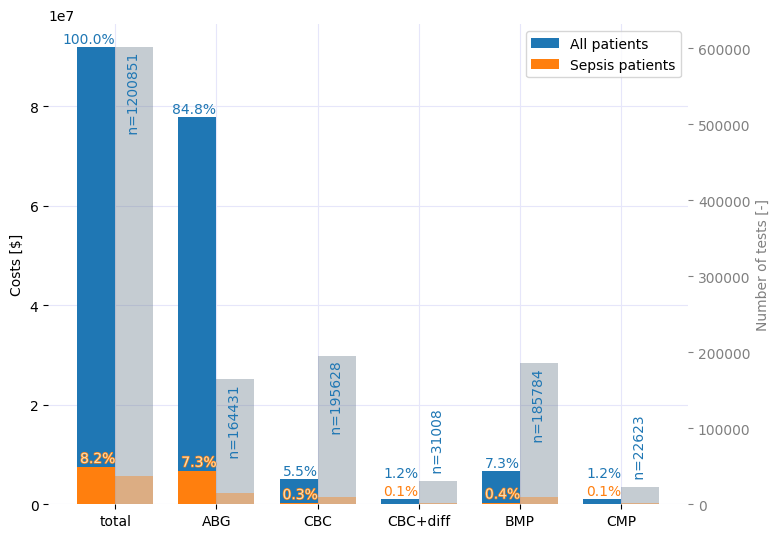

In [307]:
values = list(cost_dict.values())
values_sepsis = list(cost_dict_sepsis.values())
labels = list(cost_dict.keys())
positions = np.arange(len(labels))

# get nums and bring into right order
num_tests = [np.sum(list(test_num_dict_total.values()))]
num_tests += list(test_num_dict_total[k] for k in cost_dict.keys() if k != 'total')
num_tests_sepsis = [np.sum(list(test_num_dict_total_sepsis.values()))]
num_tests_sepsis += list(test_num_dict_total_sepsis[k] for k in cost_dict.keys() if k != 'total')


fig = plt.figure()
width = 0.375
dx = width/2  # shift bars by dx
ax = fig.add_axes([0,0,1,1])
# test costs
ax.bar(positions - dx, height=values, width=width, zorder=2, color='C0', label='All patients')
ax.bar(positions - dx, height=values_sepsis, width=width, zorder=2, color='C1', label='Sepsis patients')
ax.set_xticks(positions, labels)
ax.grid(visible=True, color='lavender')
ax.set_ylabel('Costs [$]')
ax.spines[:].set_visible(False)

# num tests
ax2 = ax.twinx() 
ax2.bar(positions + dx, height=num_tests, alpha=0.4, width=width, zorder=2, color='slategrey', label='_All patients')
ax2.bar(positions + dx, height=num_tests_sepsis, width=width, alpha=0.4, zorder=2, color='C1', label='_Sepsis patients')
ax2.spines[:].set_visible(False)


# text labels
for i, (v, v_sepsis) in enumerate(zip(values, values_sepsis)):
    number = f'{str(v)} €'
    number = num_tests[i] if i != 0 else np.sum(num_tests)
    percentage = f'{round(v / cost_dict["total"] * 100, 1)}%'
    number_sepsis = ''
    percentage_sepsis = f'{round(v_sepsis / cost_dict["total"] * 100, 1)}%'
    v = v + 100000
    v_sepsis = v_sepsis + 100000
    path_effects=[pe.withStroke(linewidth=1, foreground="C1")]
    color_sepsis = 'wheat'
    if i in [3, 5]:
        v_sepsis = v
        v += 3500000
        path_effects = None
        color_sepsis = 'C1'
    
    ax.text(i, v + 100000, f'{percentage}', ha='right', va='bottom', color='C0', rotation=0) # all patients
    ax.text(i, v_sepsis + 100000, f'{number_sepsis}\n{percentage_sepsis}', ha='right', va='bottom', color=color_sepsis, rotation=0, weight='normal', path_effects=path_effects) # sepsis patients
    va = 'top' if i in [0,1,2,4] else 'bottom'
    ax2.text(i + dx, num_tests[i] + 5000, f' n={number}  ', ha='center', va=va, color='C0', rotation=90)

# ax.text(3, 6000000, 'PRELIMINARY', color='red', fontsize=20, ha='center', va='bottom', rotation=20)
ax2.tick_params(axis='y', colors='grey')
ax2.set_ylabel('Number of tests [-]', color='grey')
ax.legend()
plt.savefig(path_figures / 'miiv_lab_costs.pdf', bbox_inches='tight')
plt.show()


In [234]:
test_num_dict_total

Counter({'CBC': 195628,
         'BMP': 185784,
         'ABG': 164431,
         'CBC+diff': 31008,
         'CRP': 1903,
         'CMP': 22623})